In [1]:

import datetime
import time

import random
import math
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm_notebook as tqdm 

import os, shutil


import skimage
from skimage.io import imread,imsave
from skimage import morphology
from skimage.filters import threshold_otsu
from skimage import img_as_uint


import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from models_pytorch import AttnUNet,init_weights,save_model,load_model
from vanilla_AUnet_Dataset import DataSet,ToTensor,Scale

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import pandas as pd 

# from preprocess import fuse_roi,generate_train_mask
# from prediction import whole_img_pred,post_process

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
batch_size_train=8
batch_size_test=8
transform=torchvision.transforms.Compose([Scale(),ToTensor()])    

img_dir_train='input_cn_overlap_train'
img_dir_test='input_cn_overlap_val'

mask_dir_train='mask_cn_overlap_train'
mask_dir_test='mask_cn_overlap_val'


train_dataset=DataSet(img_dir_train,mask_dir_train,transform=transform)
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,num_workers=0,shuffle=True)
print(train_dataset.__len__()," Train samples")

test_dataset=DataSet(img_dir_test,mask_dir_test,transform=transform)
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,num_workers=0,shuffle=True)
print(test_dataset.__len__()," Test samples")

15674  Train samples
2800  Test samples


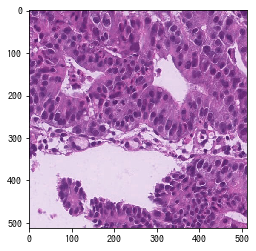

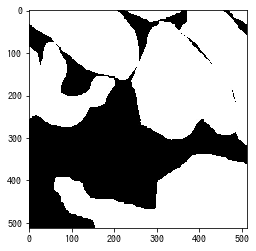

In [3]:
def visualize_loader(loader,index):
    for i,sample in enumerate(loader):
        #print(sample['image'].shape)
        if i==0:
            image=(sample['image'][index]).numpy()
            
            
            #image=np.zeros(image_i.shape,dtype=np.uint8)
            #image[np.where(image_i!=0)]=255

            
            mask=(sample['mask'][index]).numpy()
        
           
    
            image=image.transpose(1,2,0)
            
            mask=np.squeeze(mask.transpose(1,2,0),axis=2)
            
        
            fig=plt.figure()
            plt.imshow(image,cmap='gray')
            
            fig3=plt.figure()
            plt.imshow(mask,cmap='gray')
            break
visualize_loader(test_loader,1)

In [4]:
    
def dice_metric(y_pred,y_true):
    smooth = 1e-16
    num = y_true.size(0)
    m1 = y_pred.view(num, -1)
    m2 = y_true.view(num, -1)
    
        
    intersection = (m1* m2)

    score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
    score = score.sum() / num
        
    return score
    

In [5]:
model=AttnUNet(img_ch=3,output_ch=1)
model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'au_model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('model_{} dir has been made'.format(model_start_date))
print("Model's state_dict:")
writer = SummaryWriter('model_{}/experiment_{}'.format(model_start_date,1))
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


# writer.close()

Model's state_dict:


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Conv1.conv.0.weight 	 torch.Size([64, 3, 3, 3])
Conv1.conv.0.bias 	 torch.Size([64])
Conv1.conv.1.weight 	 torch.Size([64])
Conv1.conv.1.bias 	 torch.Size([64])
Conv1.conv.1.running_mean 	 torch.Size([64])
Conv1.conv.1.running_var 	 torch.Size([64])
Conv1.conv.1.num_batches_tracked 	 torch.Size([])
Conv1.conv.3.weight 	 torch.Size([64, 64, 3, 3])
Conv1.conv.3.bias 	 torch.Size([64])
Conv1.conv.4.weight 	 torch.Size([64])
Conv1.conv.4.bias 	 torch.Size([64])
Conv1.conv.4.running_mean 	 torch.Size([64])
Conv1.conv.4.running_var 	 torch.Size([64])
Conv1.conv.4.num_batches_tracked 	 torch.Size([])
Conv2.conv.0.weight 	 torch.Size([128, 64, 3, 3])
Conv2.conv.0.bias 	 torch.Size([128])
Conv2.conv.1.weight 	 torch.Size([128])
Conv2.conv.1.bias 	 torch.Size([128])
Conv2.conv.1.running_mean 	 torch.Size([128])
Conv2.conv.1.running_var 	 torch.Size([128])
Conv2.conv.1.num_batches_tracked 	 torch.Size([])
Conv2.conv.3.weight 	 torch.Size([128, 128, 3, 3])
Conv2.conv.3.bias 	 torch.Size([128])
Con

In [6]:

optimizer_selected='adam'
batchsize=4
no_steps=train_dataset.__len__()//batchsize
restart_epochs=5
num_epochs=10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device=="cuda:0":
    print(torch.cuda.get_device_name(torch.cuda.current_device()))

#criterion = SoftDiceLoss()#
criterion=nn.BCELoss()

history={'train_loss':[],'test_loss':[],'train_dice':[],'test_dice':[]}
model = model.to(device)
if optimizer_selected=='adam':
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-02, betas=(0.9, 0.98))#,weight_decay=0.02)
else:
    optimizer = torch.optim.SGD(model.parameters(),lr=1e-03, momentum=0.8,nesterov=True)

scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, restart_epochs*no_steps,\
                                                     eta_min=1e-012, last_epoch=-1)


best_val=0
for epoch in range(num_epochs):
    
    print("Learning Rate : {}".format(optimizer.state_dict()['param_groups'][-1]['lr']))
    # loop over the dataset multiple times
    
    run_avg_train_loss=0
    run_avg_train_dice=0
    
   
    
    run_avg_test_loss=0
    run_avg_test_dice=0
    
    for mode in ['train','eval']:
     
        if mode == 'train':
            
            model.train()
            loop=tqdm(train_loader)
            
            for i, sample_batched in (enumerate(loop)):
                loop.set_description('Epoch {}/{}'.format(epoch + 1, num_epochs))
                
                #Clear Gradients
                optimizer.zero_grad()
                
                # get the inputs; data is a list of [dapi, nuclei, boundary]
                image_train,mask_train = sample_batched['image'],sample_batched['mask']
                
                image_train,mask_train = image_train.to(device, dtype = torch.float)\
                ,mask_train.to(device, dtype = torch.float)

                # forward + backward + optimize
                outputs = torch.sigmoid(model(image_train))
                
                loss = criterion(outputs, mask_train)
                dice_score=dice_metric(outputs,mask_train)
                run_avg_train_loss=(run_avg_train_loss*(0.9))+loss.detach().item()*0.1
                run_avg_train_dice=(run_avg_train_dice*(0.9))+dice_score.detach().item()*0.1
               
                if i%100==99:
                    
                
                    
                    img_tensor=torch.cat((outputs.detach().cpu()\
                                          ,mask_train.detach().cpu()),axis=0)
                    
                    
            
                    img_grid2 = torchvision.utils.make_grid(img_tensor*255,nrow=batch_size_train,padding=100)
                    torchvision.utils.save_image(img_grid2,os.path.join(BEST_MODEL_PATH,\
                                                                        'train_iter_{}.png'\
                                                                        .format(epoch*len(train_loader)+i+1)))
                    writer.add_image('TRAIN_ITER_{}'.format(epoch * len(train_loader) + i+1), img_grid2)
                    
                    
                    writer.add_scalar('Training dice score nuclei',
                            run_avg_train_dice,
                            epoch * len(train_loader) + i+1)
                
                    writer.add_scalar('Training Loss',
                            run_avg_train_loss,
                            epoch * len(train_loader) + i+1)
                    
                loss.backward()
                optimizer.step()
                
                scheduler.step()
                
                
                loop.set_postfix(loss=run_avg_train_loss,dice_score=run_avg_train_dice)
               
            history['train_loss'].append(run_avg_train_loss)
            history['train_dice'].append(run_avg_train_dice)
                
                 
                    
        elif mode =='eval':
            #Clear Gradients
            optimizer.zero_grad()
            samples_test=len(test_loader)
            model.eval()
            val_loss=0
            test_agg=0
            for j, test_sample in enumerate(test_loader):

                image_test, mask_test = test_sample['image'],test_sample['mask']
                
                image_test, mask_test = image_test.to(device, dtype = torch.float),\
                mask_test.to(device, dtype = torch.float)
                test_outputs = torch.sigmoid(model(image_test))
                
                test_loss = criterion(test_outputs, mask_test)
                #final_test_loss+=test_loss.detach().item()
                test_dice=dice_metric(test_outputs,mask_test)
                #final_test_dice+=test_dice
                run_avg_test_loss=(run_avg_test_loss*(0.9))+test_loss.detach().item()*0.1
                run_avg_test_dice=(run_avg_test_dice*(0.9))+test_dice.detach().item()*0.1
               
                if j%100==99:
                    
                    img_tensor_test=torch.cat((test_outputs.detach().cpu(),mask_test.detach().cpu()),axis=0)
                    
                    
                    img_grid = torchvision.utils.make_grid(img_tensor_test*255,nrow=batch_size_test,padding=10)
                    torchvision.utils.save_image(img_grid,os.path.join(BEST_MODEL_PATH,\
                                                                        'test_iter_{}.png'\
                                                                        .format(epoch*len(test_loader)+j+1)))
                    writer.add_image('TEST_ITER_{}'.format(epoch * len(test_loader) + j+1), img_grid)
                    writer.add_scalar('Testing dice score ',\
                                      run_avg_test_dice,epoch * len(test_loader) + j+1)
                    
                    writer.add_scalar('Testing Loss',\
                                      run_avg_test_loss,epoch * len(test_loader) + j+1)
                
            print("test_loss: {}\ntest_dice :{}"\
                  .format(run_avg_test_loss,run_avg_test_dice))
            history['test_loss'].append(run_avg_test_loss)
            history['test_dice'].append(run_avg_test_dice)
            if run_avg_test_dice>best_val:
                best_val=run_avg_test_dice
                save_model(model,optimizer,BEST_MODEL_PATH+'/model_optim.pth',scheduler=None)
                
                print("saved model with test dice score: {}".format(best_val))

        
#             print("val_loss {}".format(val_loss/samples_test))
save_model(model,optimizer,BEST_MODEL_PATH+'/model_final.pth',scheduler=None)

print('Finished Training')

Learning Rate : 0.01


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 3 and 1 in dimension 1 at /pytorch/aten/src/TH/generic/THTensor.cpp:689

In [8]:
!ls

Colon_post.ipynb		mask_cn_overlap_train
colon_unet_keras.ipynb		mask_cn_overlap_val
colon_unet_resized_keras.ipynb	masked_img
Digest_DualEncoding.ipynb	mask_patches_test
digest_patchExtractor.py	mask_patches_train
DigestPath_Dataset.py		mask_test
entire_image_2019_10_14		mask_train
input_cn_overlap_test		model_2019_08_26
input_cn_overlap_train		model_2019_08_29
input_cn_overlap_val		model_2019_08_30
__MACOSX			model_non_cn_unet2019_10_04
map_1				model_non_overlap_unet2019_10_10
map_1_gray			models_pytorch.py
map_1_gray_matlab		model_vanilla_unet2019_10_01
map_1_matlab			norm_images.ipynb
map_1_patches_test		patch_extractor.ipynb
map_1_patches_train		patch_extractor_v1.py
map_1_test			predictions.csv
map_1_train			predict_unet_colon_keras.ipynb
map_2				__pycache__
map_2_gray			requirements_datalab.txt
map_2_gray_matlab		requirements.txt
map_2_matlab			sample.png
map_2_patches_test		tissue-train-neg_norm
map_2_patches_train		tissue-train-pos-v1_color_normalized
map_2_test			tissue-trai